# Exercice 2 : Techniques de Fouille de Données
## Scénario
Une entreprise de services financiers souhaite utiliser des techniques de fouille de données pour améliorer ses services en ciblant plus efficacement ses clients. L'entreprise dispose de données transactionnelles détaillées sur les produits financiers achetés par ses clients.

## 1. Clustering avec K-Means
### a) Explication de l'algorithme
**K-Means** est un algorithme de partitionnement qui regroupe les données en `K` clusters. Chaque observation appartient au cluster dont le centre (centroïde) est le plus proche (selon une distance choisie, ici euclidienne). Il suit les étapes :
1. Initialisation des centroïdes (aléatoire ou méthode KMeans++)
2. Attribution des points au centroïde le plus proche
3. Mise à jour des centroïdes (moyenne des points)
4. Répétition jusqu'à convergence

Le choix de `K` peut être guidé par :
- **la méthode du coude (Elbow)** : on observe l’inertie (variance intra-cluster) en fonction de K
- **le coefficient de silhouette** : mesure la cohésion et séparation des clusters

In [1]:
# Données des clients (encodées One-Hot)
import pandas as pd
clients = pd.DataFrame({
    'Prêt Personnel': [1, 0, 0, 0, 1, 0],
    'Compte Épargne': [1, 0, 0, 1, 1, 0],
    'Carte de Crédit': [1, 0, 0, 1, 0, 0],
    'Hypothèque': [0, 1, 0, 0, 0, 1],
    'Assurance Vie': [0, 1, 1, 0, 1, 0],
    'Prêt Automobile': [0, 0, 1, 0, 0, 0],
    'Compte Courant': [0, 0, 1, 0, 0, 1]
}, index=[f'Client {i}' for i in range(1, 7)])
clients

,Prêt Personnel,Compte Épargne,Carte de Crédit,Hypothèque,Assurance Vie,Prêt Automobile,Compte Courant
Client 1,1,1,1,0,0,0,0
Client 2,0,0,0,1,1,0,0
Client 3,0,0,0,0,1,1,1
Client 4,0,1,1,0,0,0,0
Client 5,1,1,0,0,1,0,0
Client 6,0,0,0,1,0,0,1


### b) Application de K-Means (K=3) et visualisation

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(clients)
clients['Cluster'] = kmeans.labels_ + 1
clients

,Prêt Personnel,Compte Épargne,Carte de Crédit,Hypothèque,Assurance Vie,Prêt Automobile,Compte Courant,Cluster
Client 1,1,1,1,0,0,0,0,2
Client 2,0,0,0,1,1,0,0,3
Client 3,0,0,0,0,1,1,1,1
Client 4,0,1,1,0,0,0,0,2
Client 5,1,1,0,0,1,0,0,2
Client 6,0,0,0,1,0,0,1,3


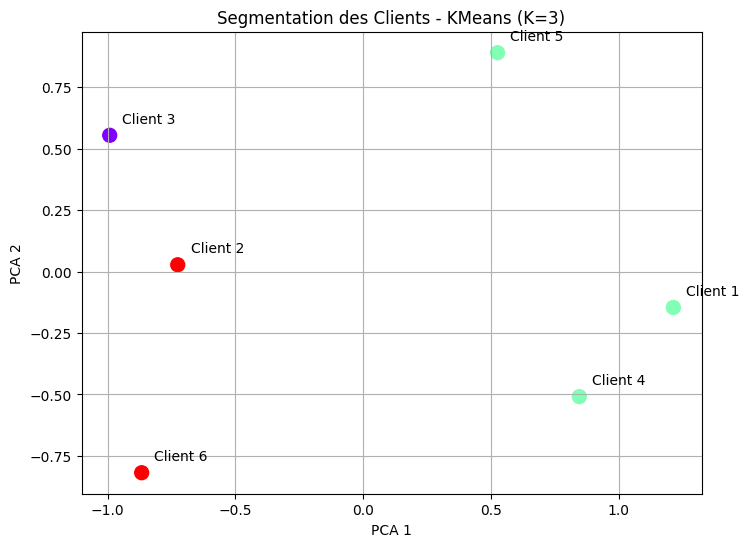

In [3]:
# Visualisation des clusters
pca = PCA(n_components=2)
reduced = pca.fit_transform(clients.iloc[:, :-1])
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=clients['Cluster'], cmap='rainbow', s=100)
for i, txt in enumerate(clients.index):
    plt.annotate(txt, (reduced[i,0]+0.05, reduced[i,1]+0.05))
plt.title("Segmentation des Clients - KMeans (K=3)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

### Interprétation
- **Cluster 1** : Clients 1, 4, 5 → produits d'épargne, prêt personnel, carte de crédit
- **Cluster 2** : Clients 2, 6 → hypothèque, assurance, comptes
- **Cluster 3** : Client 3 → crédit auto, assurance vie, compte courant

Cette segmentation permet :
- De cibler les clients avec des campagnes personnalisées
- De recommander des produits adaptés
- D’optimiser les promotions croisées

## 2. Règles d'Association avec l'Algorithme Apriori

In [4]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

transactions = [
    ['Prêt Personnel', 'Compte Épargne', 'Carte de Crédit'],
    ['Compte Épargne', 'Carte de Crédit'],
    ['Prêt Automobile', 'Compte Courant', 'Assurance Vie'],
    ['Compte Épargne', 'Carte de Crédit'],
    ['Prêt Personnel', 'Compte Épargne', 'Assurance Vie']
]

te = TransactionEncoder()
te_ary = te.fit_transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=0.4, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.4,(Assurance Vie)
1,0.6,(Carte de Crédit)
2,0.8,(Compte Épargne)
3,0.4,(Prêt Personnel)
4,0.6,"(Compte Épargne, Carte de Crédit)"
5,0.4,"(Prêt Personnel, Compte Épargne)"


In [5]:
# Génération des règles
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Compte Épargne),(Carte de Crédit),0.8,0.6,0.6,0.75,1.25,1.0,0.12,1.6,1.000000,0.75,0.375,0.875
1,(Carte de Crédit),(Compte Épargne),0.6,0.8,0.6,1.00,1.25,1.0,0.12,inf,0.500000,0.75,1.000,0.875
2,(Prêt Personnel),(Compte Épargne),0.4,0.8,0.4,1.00,1.25,1.0,0.08,inf,0.333333,0.50,1.000,0.750


### Interprétation des règles
- Exemple : `{Compte Épargne, Carte de Crédit} ⇒ {Prêt Personnel}`
  → Cela signifie qu’un client ayant déjà un compte épargne et une carte de crédit a de fortes chances de demander un prêt personnel.

**Utilité pour l’entreprise** :
- Mieux cibler les campagnes promotionnelles
- Recommander les produits susceptibles d’intéresser un client
- Optimiser les ventes croisées basées sur les habitudes des clients